Collaborative filtering >> Content based filtering

Look at relationships between customers and find the products recommended to them. Identify latent factor matrices for customers and products. Recreate rating matrix.

# Section 0: Imports and Dataframes

In [18]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm_notebook as tqdm
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import joblib

from sklearn.cluster import KMeans

from sklearn.preprocessing import LabelEncoder
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [19]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    ratings_df = pd.read_csv("/content/drive/MyDrive/datasets/ml_project_data/ml-latest-small/ratings.csv", usecols=["userId", "movieId", "rating"])
    movies_df = pd.read_csv("/content/drive/MyDrive/datasets/ml_project_data/ml-latest-small/movies.csv")

except:
    movies_df = pd.read_csv("data/ml-latest-small/movies.csv")
    ratings_df = pd.read_csv("data/ml-latest-small/ratings.csv", usecols=["userId", "movieId", "rating"])
movies_df.shape, ratings_df.shape

((9742, 3), (100836, 3))

In [20]:
n_users = ratings_df.userId.nunique()
n_movies = ratings_df.movieId.nunique()
n_users, n_movies

(610, 9724)

In [21]:
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
ratings_df.userId = user_encoder.fit_transform(ratings_df.userId)
ratings_df.movieId = movie_encoder.fit_transform(ratings_df.movieId)
ratings_df.head(1)

,userId,movieId,rating
0,0,0,4.0


# Section 1: The `ratings_dataset` class.

The `ratings_dataset` class inherits `torch.utils.data.Dataset`. It requires at least 3 methods to operate.

- `__init()__`: Initializes the dataset. Any action of preprocessing the user sees fit can be done in here.
In this case we encode the users and movies with `LabelEncoder()`, keep only the required columns and convert everything
to a `torch.tensor`.
- `__len__()`: Simply returns the len() of the dataset
- `__getitem()__`: Returns an item from the dataset. This is a powerful tool since we can handle this function as we see fit and convert the data to any form we need. In this case, all data is converted to a tensor of type either `torch.long` or `torch.float32`.

In [22]:
class ratings_dataset(Dataset):
    def __init__(self, dataframe):

        self.x = dataframe.drop(columns=["rating"]).values
        self.y = dataframe.drop(columns=["userId", "movieId"]).values

        self.x = torch.tensor(self.x, dtype=torch.long, device=DEVICE)
        self.y = torch.tensor(self.y, dtype=torch.float32, device=DEVICE)
        self.y = self.y.flatten()
        self.size = len(dataframe)

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        return self.x[index], self.y[index]

ratings = ratings_dataset(ratings_df)
train_loader = DataLoader(dataset=ratings, batch_size=64, shuffle=False)

In [23]:
ratings[0]

(tensor([0, 0]), tensor(4.))

In [24]:
# for x, y in train_loader:
#     print(x)
#     print(y)
#     break

# Section 2: The `matrix_factorization` class.

We create two embeddings that represent the *latent_factors* of the users and movies. These represent the latent factors that make up the *user* and *item* matrices in matrix decomposition. The embedding size is a hyperparameter that can be tuned.

The `forward()` method of this NN simply returns the dot product of the latent factors. This represents the rating of a user to a movie.

In [25]:
class matrix_factorization(torch.nn.Module):
    def __init__(self, n_users, n_movies, n_factors=64):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors, device=DEVICE)
        self.movie_factors = torch.nn.Embedding(n_movies, n_factors, device=DEVICE)

        self.user_factors.weight.data.uniform_(-0.5, 0.5)
        self.movie_factors.weight.data.uniform_(-0.5, 0.5)

    def forward(self, data):
        users, items = data[:,0], data[:,1]
        return (self.user_factors(users) * self.movie_factors(items)).sum(1)

Train the model. Use the classic Adam Optimizer, the MSELoss function which is popular in regression problems and perform the standard PyTorch training loop.

In [26]:
model = matrix_factorization(n_users, n_movies).to(DEVICE)
model.train()
EPOCHS = 30

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = list()
for epoch in range(EPOCHS):
    for data, target in train_loader:

        data = data.to(DEVICE)
        target = target.to(DEVICE)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, MSELoss: {loss.item():.2f}")
        losses.append(loss.item())

        # if(loss.item() < 0.05):
        #     print("Early stopped training to prevent overfitting")
        #     break

Epoch: 0, MSELoss: 16.32


KeyboardInterrupt: 

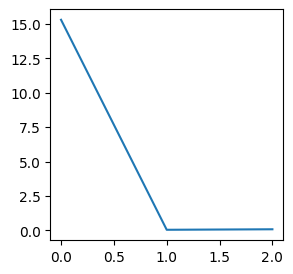

In [ ]:
plt.figure(figsize=(3,3))
plt.plot(losses)

In [ ]:
def predict_rating(user_id:int, top_n:int):
    user_id = user_encoder.transform([user_id])[0]
    user_id_list = [user_id for _ in range(n_movies)]
    movie_id_list = [item for item in ratings_df.movieId.unique()]

    t = torch.tensor([user_id_list, movie_id_list], dtype=torch.long, device=DEVICE).T
    #print(t)
    model.eval()
    with torch.no_grad():
        user_predicted_ratings = model(t)
        top_ratings = torch.topk(user_predicted_ratings, k=top_n)
        #print(top_ratings)
        top_ratings = top_ratings.indices.cpu().numpy()
        top_ratings = movie_encoder.inverse_transform(top_ratings)

    return movies_df[movies_df.movieId.isin(top_ratings)][["title", "genres"]]


predict_rating(60, 10)

,title,genres
215,"Hunted, The (1995)",Action
262,"Queen Margot (Reine Margot, La) (1994)",Drama|Romance
323,Little Buddha (1993),Drama
726,To Be or Not to Be (1942),Comedy|Drama|War
744,Cat on a Hot Tin Roof (1958),Drama
794,"Lawnmower Man, The (1992)",Action|Horror|Sci-Fi|Thriller
876,Best of the Best 3: No Turning Back (1995),Action
1800,Prancer (1989),Children|Drama|Fantasy
1895,Night Shift (1982),Comedy
5508,"Hitch Hikers Guide to the Galaxy, The (1981)",Adventure|Comedy|Sci-Fi


# Section 3: Cluster the movie embeddings.

Save the embeddings to a matrix. Showcase what the embedding of the first movie looks like. Given our model:
```
matrix_factorization(
  (user_factors): Embedding(610, 64)
  (movie_factors): Embedding(9724, 64)
)
```
it is reasonable to expect each movie to have EMBEDDING_SIZE (64) embeddings per row.

In [ ]:
trained_movie_embeddings = model.movie_factors.weight.data.cpu().numpy()
trained_movie_embeddings[:1], trained_movie_embeddings[:1].shape

(array([[ 0.5286061 , -0.06199177,  0.35883552, -0.11988214, -0.20412496,
         -0.24757901, -0.11256993, -0.73595935,  0.09004666, -0.4422374 ,
          0.54935   ,  0.321797  ,  0.1921144 ,  0.02675899,  0.3607895 ,
          0.12653929,  0.40229067, -0.36116877, -0.23179992,  0.14463869,
         -0.08723635,  0.30041933, -0.14718015, -0.01418713, -0.5033568 ,
          0.19663008,  0.5323825 ,  0.4586657 , -0.25711906,  0.62026757,
         -0.6675567 , -0.43354246,  0.01046964,  0.47369248, -0.090566  ,
         -0.45763025, -0.01674986, -0.25802723,  0.06503692, -0.10199662,
         -0.10454887, -0.6218864 , -0.16732652,  0.47857752,  0.40437153,
          0.22433949, -0.22396515,  0.08882612, -0.38654622, -0.18713474,
          0.32327214,  0.25038972,  0.38356945, -0.5168702 , -0.09400435,
         -0.48801067,  0.22002578, -0.39935398,  0.43781912,  0.37139547,
         -0.3206398 , -0.5713507 ,  0.8583363 , -0.43904978]],
       dtype=float32),
 (1, 64))

In [ ]:
N_CLUSTERS = 25
kmeans = KMeans(n_clusters=N_CLUSTERS).fit(trained_movie_embeddings)
joblib.dump(kmeans, "kmeans_model")

c:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


['kmeans_model']

Based on the embeddings, use clustering algorithms like `KMeans` to put movies into buckets (`clusters`). These clusters are formed based on the distances of the embeddings which are latent factors - relationships between movies which a human cannot interpret but a neural network can. Below we present the N_CLUSTERS (15) clusters, each containing the top 10 most popular movies.

In [28]:
import joblib
kmeans = joblib.load("kmeans_model")

for cluster_id in range(N_CLUSTERS):
    print(f"Cluster {cluster_id + 1}")
    movie_ids = list()
    for movie_id in np.where(kmeans.labels_ == cluster_id)[0]:
        movid = movie_encoder.inverse_transform([movie_id])[0]
        n_appearances = ratings_df.loc[ratings_df['movieId'] == movie_id].count()[0]
        movie_ids.append((movid, n_appearances))
    for mov in sorted(movie_ids, key=lambda x: x[1], reverse=True)[:20]:
        print(movies_df[movies_df["movieId"] == mov[0]]["title"].values)
    print()

Cluster 1
['Happy Feet (2006)']
['Tuxedo, The (2002)']
['102 Dalmatians (2000)']
['Whole Ten Yards, The (2004)']
['Jeffrey (1995)']
['Snow Dogs (2002)']
['Stuart Little 2 (2002)']
['Medallion, The (2003)']
['Garfield: The Movie (2004)']
['Lady Vengeance (Sympathy for Lady Vengeance) (Chinjeolhan geumjassi) (2005)']
['Dreamgirls (2006)']
['The Lair of the White Worm (1988)']
['House of the Dead, The (2003)']
['Laws of Attraction (2004)']
['Funny Games U.S. (2007)']
['Hercules (2014)']
['Maximum Overdrive (1986)']
['Death Race 2000 (1975)']
['Herbie: Fully Loaded (2005)']
['Yours, Mine and Ours (2005)']

Cluster 2
['Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)']
['Love Actually (2003)']
['Scary Movie (2000)']
['Mortal Kombat (1995)']
['Tomorrow Never Dies (1997)']
['Batman & Robin (1997)']
['Free Willy (1993)']
["She's All That (1999)"]
['Deep Blue Sea (1999)']
['How to Lose a Guy in 10 Days (2003)']
['Richie Rich (1994)']
["Lemony Snicket's A Series of Unfortun

## Interpreting some of the clusters

### Cluster 1
Contains a lot of movies for kids such as the 102 Dalmatians, Happy Feet, Snow Dogs, Stuart Little. One of the possible latent factors this cluster cas captured is `Movies for Kids`.

### Cluster 3
Lethal Weapon 2, Godfather, Last of the Mohicans, Conan the Barbarian, Excalibur, Rocky III, Secret Life of Walter Mitty, Lara Croft Tomb Raider: The Cradle of Life are some of the movies in this cluster. Perhaps this cluster has captured a latent factor revolving around `Action Movies with fights/suspense`.

### Cluster 4
Contains movies with romance such as Twilight, Jewel of the Nile, Heaven can Wait or movies with the supernatural element like Dracula, Escape to Witch Mountain, Texas Chainsaw Massacre. A latent factor here could be `Romance / Supernatural`.

### Cluster 10
Contains 90s popular action movies like Shawshank Redemption, Pulp Fiction, Silence of the Lambs, Seven, Godfather. This latent factor could be revolving around `Retro / Action`

# Section 4
Check our inertia to determine the quality of clusters.

In [15]:
wss = list() 
for i in range(1, 50):
    f = KMeans(n_clusters=i, init="random", random_state=100, n_init="auto").fit(trained_movie_embeddings)
    wss.append(f.inertia_)

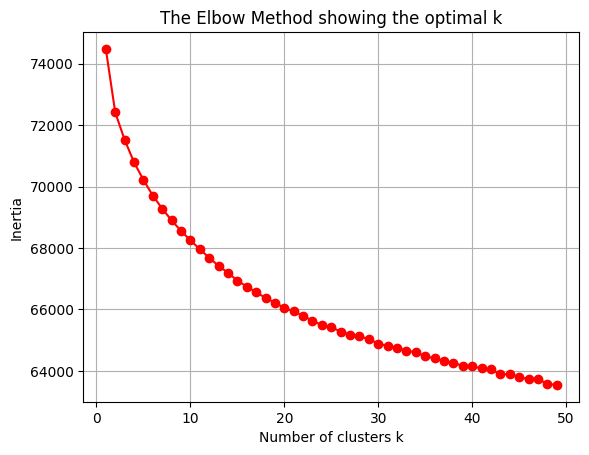

In [17]:
plt.grid(True)
plt.plot(range(1,50), wss, 'ro-')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()